In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-ybjc6ned
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-ybjc6ned
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=bfd1e9d8fd27e02925a33f604073722f302ea75f2a08fae4f7ae84cab14751ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-ftjz3j19/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


Śledzenie promieni, wsteczne śledzenie promieni (ang. ray tracing, backward raytracing) – technika generowania fotorealistycznych obrazów scen trójwymiarowych opierająca się na analizowaniu tylko tych promieni światła, które trafiają bezpośrednio do obserwatora. W rekursywnym śledzeniu promieni bada się dodatkowo promienie odbite, zwierciadlane oraz załamane. Ponadto umożliwia łatwą realizację CSG, a także wizualizację idealnych, opisywanych formułami matematycznymi obiektów. Odwrotne podejście do techniki śledzenia promieni realizuje metoda prostego śledzenie promieni (ang. forward raytracing). 

In [ ]:
%%cu
#include <stdio.h>

#define DIM 1024
#define rnd( x ) (x * rand() / RAND_MAX)
#define INF     2e10f
struct Sphere {
    float   r,b,g;
    float   radius;
    float   x,y,z;
    __device__ float hit( float ox, float oy, float *n ) {
        float dx = ox - x;
        float dy = oy - y;
        if (dx*dx + dy*dy < radius*radius) {
            float dz = sqrtf( radius*radius - dx*dx - dy*dy );
            *n = dz / sqrtf( radius * radius );
            return dz + z;
        }
        return -INF;
    }
};
#define SPHERES 20


__global__ void kernel( Sphere *s, unsigned char *ptr ) {
    // map from threadIdx/BlockIdx to pixel position
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    int offset = x + y * blockDim.x * gridDim.x;
    float   ox = (x - DIM/2);
    float   oy = (y - DIM/2);

    float   r=0, g=0, b=0;
    float   maxz = -INF;
    for(int i=0; i<SPHERES; i++) {
        float   n;
        float   t = s[i].hit( ox, oy, &n );
        if (t > maxz) {
            float fscale = n;
            r = s[i].r * fscale;
            g = s[i].g * fscale;
            b = s[i].b * fscale;
            maxz = t;
        }
    } 

    ptr[offset*4 + 0] = (int)(r * 255);
    ptr[offset*4 + 1] = (int)(g * 255);
    ptr[offset*4 + 2] = (int)(b * 255);
}


// globals needed by the update routine
struct DataBlock {
    unsigned char *dev_bitmap;
};

void save_to_file(unsigned char *ptr) {
    FILE *fp=fopen("GPU_RayTracing.txt", "w");
    fprintf(fp, "%d %d\n", DIM, DIM);
    for(int y=0; y<DIM; y++){
        for(int x=0; x<DIM; x++){
            int offset = x+y*DIM;
            fprintf(fp, "%d, %d, %d ", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
    }
    fclose(fp);
}

int main( void ) {
    // capture the start time
    cudaEvent_t     start, stop;
    cudaEventCreate( &start );
    cudaEventCreate( &stop );
    cudaEventRecord( start, 0 );

    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM*DIM*4;
    unsigned char *dev_bitmap;

    // allocate memory on the GPU for the output bitmap
    cudaMalloc((void**)&dev_bitmap, image_size);
    data.dev_bitmap = dev_bitmap;
    Sphere *s;
    cudaMalloc((void**)&s, sizeof(Sphere) * SPHERES );

    // allocate temp memory, initialize it, copy to
    // memory on the GPU, then free our temp memory
    Sphere *temp_s = (Sphere*)malloc( sizeof(Sphere) * SPHERES );
    for (int i=0; i<SPHERES; i++) {
        temp_s[i].r = rnd( 1.0f );
        temp_s[i].g = rnd( 1.0f );
        temp_s[i].b = rnd( 1.0f );
        temp_s[i].x = rnd( 1000.0f ) - 500;
        temp_s[i].y = rnd( 1000.0f ) - 500;
        temp_s[i].z = rnd( 1000.0f ) - 500;
        temp_s[i].radius = rnd( 100.0f ) + 20;
    }
    cudaMemcpy( s, temp_s, sizeof(Sphere) * SPHERES, cudaMemcpyHostToDevice );
    free( temp_s );

    // generate a bitmap from our sphere data
    dim3    grids(DIM/16,DIM/16);
    dim3    threads(16,16);
    kernel<<<grids,threads>>>( s, dev_bitmap );

    // copy our bitmap back from the GPU for display
    cudaMemcpy( bitmap, dev_bitmap, image_size, cudaMemcpyDeviceToHost );

    // get stop time, and display the timing results
    cudaEventRecord( stop, 0 );
    cudaEventSynchronize( stop );
    float   elapsedTime;
    cudaEventElapsedTime( &elapsedTime, start, stop );
    printf( "Time to generate:  %3.1f ms\n", elapsedTime );

    cudaEventDestroy( start );
    cudaEventDestroy( stop );

    cudaFree( dev_bitmap );
    cudaFree( s );

    save_to_file(bitmap);
}


Time to generate:  1.3 ms



Time to generate:  12.1 ms DIM 2048


Time to generate:  1.3 ms  DIM 1024





In [ ]:
import re
import numpy as np
from PIL import Image
from pathlib import Path

contents = Path('GPU_RayTracing.txt').read_text()

h, w, *pixels = re.findall(r'[0-9]+', contents)

na = np.array(pixels, dtype=np.uint8).reshape((int(h),int(w),3))

Image.fromarray(na).save("wynikGPU_RT.png")

In [ ]:
%%cu
#include <stdio.h>

#define DIM 1024
#define rnd( x ) (x * rand() / RAND_MAX)
#define INF     2e10f
struct Sphere {
    float   r,b,g;
    float   radius;
    float   x,y,z;
    float hit( float ox, float oy, float *n ) {
        float dx = ox - x;
        float dy = oy - y;
        if (dx*dx + dy*dy < radius*radius) {
            float dz = sqrtf( radius*radius - dx*dx - dy*dy );
            *n = dz / sqrtf( radius * radius );
            return dz + z;
        }
        return -INF;
    }
};
#define SPHERES 20


void kernel( Sphere *s, unsigned char *ptr ) {
    for(int y=0; y<DIM; y++){
        for(int x=0; x<DIM; x++){
                float ox = (x-DIM/2);
                float oy = (y-DIM/2);
                float r=0, g=0,b=0;
                float maxz = -INF;
                int offset = x + y * DIM;  
                
          for(int i=0; i<SPHERES; i++){                   
                float n;
                float t = s[i].hit( ox, oy, &n);
                if( t > maxz) {
                    float fscale = n;
                    r=s[i].r * fscale;
                    g=s[i].g * fscale;
                    b=s[i].b * fscale;
                    maxz = t;
        }
    } 

    ptr[offset*4 + 0] = (int)(r * 255);
    ptr[offset*4 + 1] = (int)(g * 255);
    ptr[offset*4 + 2] = (int)(b * 255);
}
    }
}

struct DataBlock {
    unsigned char *dev_bitmap;
};

void save_to_file(unsigned char *ptr) {
    FILE *fp=fopen("CPU_RayTracing.txt", "w");
    fprintf(fp, "%d %d\n", DIM, DIM);
    for(int y=0; y<DIM; y++){
        for(int x=0; x<DIM; x++){
            int offset = x+y*DIM;
            fprintf(fp, "%d, %d, %d ", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
    }
    fclose(fp);
}

int main( void ) {
    // capture the start time
    cudaEvent_t     start, stop;
    cudaEventCreate( &start );
    cudaEventCreate( &stop );
    cudaEventRecord( start, 0 );

    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    Sphere *s;
    Sphere *temp_s = (Sphere*)malloc( sizeof(Sphere) * SPHERES );
    s = temp_s;
    for (int i=0; i<SPHERES; i++) {
        temp_s[i].r = rnd( 1.0f );
        temp_s[i].g = rnd( 1.0f );
        temp_s[i].b = rnd( 1.0f );
        temp_s[i].x = rnd( 1000.0f ) - 500;
        temp_s[i].y = rnd( 1000.0f ) - 500;
        temp_s[i].z = rnd( 1000.0f ) - 500;
        temp_s[i].radius = rnd( 100.0f ) + 20;
    }
    kernel(s, bitmap);


    // get stop time, and display the timing results
    cudaEventRecord( stop, 0 );
    cudaEventSynchronize( stop );
    float   elapsedTime;
    cudaEventElapsedTime( &elapsedTime, start, stop );
    printf( "Time to generate:  %3.1f ms\n", elapsedTime );
    cudaEventDestroy( start );
    cudaEventDestroy( stop );

    save_to_file(bitmap);
}


Time to generate:  149.0 ms



Time to generate:  616.8 ms DIM 2048

Time to generate:  149.0 ms DIM 1024







In [ ]:
import re
import numpy as np
from PIL import Image
from pathlib import Path

contents = Path('CPU_RayTracing.txt').read_text()

h, w, *pixels = re.findall(r'[0-9]+', contents)

na = np.array(pixels, dtype=np.uint8).reshape((int(h),int(w),3))

Image.fromarray(na).save("wynikCPU_RT.png")

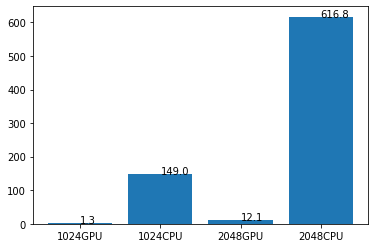

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])
x = np.array(["1024GPU", "1024CPU", "2048GPU", "2048CPU"])
y = np.array([1.3 , 149.0, 12.1, 616.8])
z = y
plt.bar(x,y,0.8)
addlabels(x, y)
plt.show()